In [1]:
import geopandas as gpd
import pandas as pd
from covid19dh import covid19
import requests
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
import contextily as ctx

## Airports

In [29]:
airports = gpd.read_file('../raw data/Trans_AirportPoint.shp')

In [30]:
public_airports = airports[(airports.fcode == 20000) & (airports.ownertype == 1)]
public_airports

,faa_airpor,fcode,GLOBALID,gnis_id,loaddate,name,ownership,ownertype,permanent_,source_dat,source_d_1,source_fea,source_ori,ftype,ObjectID,geometry
4,C00,20000,{449F68EA-3991-4179-AD92-AAF743ACB8CF},427006,2021-06-22,Mercer County Airport,1,1,f85a4fb0-89b6-4dd4-910a-fc2e324066e2,"Public and Private Airports, Heliports, and Se...",{5A23F3CF-C3EB-4C80-8E3C-4BB35EC03748},None,Federal Aviation Administration,200,4,POINT (-90.73693 41.25095)
12,MLI,20000,{B4AD95A8-2401-47B7-AEB0-0EEE41C4A797},427554,2021-09-13,Quad Cities International Airport,1,1,fee9ccd7-fe07-439a-8f8f-d094057d7656,"Public and Private Airports, Heliports, and Se...",{1F308FC9-B6E1-4D01-AB93-ECA2C42E6D0B},None,Federal Aviation Administration,200,12,POINT (-90.50558 41.45238)
18,3G8,20000,{C5D2A65D-58BE-42BE-943B-66EFC0913C4C},427307,2021-06-22,Gen-Airpark,1,1,88cb055d-e5c0-4d5e-92b3-b5e27de5a0b9,"Public and Private Airports, Heliports, and Se...",{5A23F3CF-C3EB-4C80-8E3C-4BB35EC03748},None,Federal Aviation Administration,200,18,POINT (-90.11328 41.44023)
29,5K4,20000,{5A9DB20E-699D-4DE0-840B-D1D8DEA3FFE8},427776,2021-06-22,Schuy-Rush Airport,1,1,d8cbe961-a92d-408d-9938-80e67ff9e1e7,"Public and Private Airports, Heliports, and Se...",{5A23F3CF-C3EB-4C80-8E3C-4BB35EC03748},None,Federal Aviation Administration,200,29,POINT (-90.59452 40.11766)
32,9I0,20000,{57BAD01A-4612-4F64-BA12-21641DF0A743},427363,2021-06-22,Havana Regional Airport,1,1,4e02a02b-664d-4292-98b5-1fdfc62334a6,"Public and Private Airports, Heliports, and Se...",{5A23F3CF-C3EB-4C80-8E3C-4BB35EC03748},None,Federal Aviation Administration,200,32,POINT (-90.02289 40.22115)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1103,PJY,20000,{0D673651-CD5F-4D6A-AD7D-2C0281F33DB2},427682,2022-03-17,Pinckneyville/Du Quoin Airport,1,1,5bceb8ab-4c2c-4e5c-9233-bbff3c9f3b15,"Public and Private Airports, Heliports, and Se...",{47C1E790-9908-4F92-AB7A-953DC4A32736},None,Federal Aviation Administration,200,1103,POINT (-89.36308 37.97731)
1111,MDH,20000,{7B7241CF-1A73-421D-AFA0-AE9C9C525E66},427102,2021-06-22,Southern Illinois Airport,1,1,8fe5f746-97b9-4ce2-9194-53b2fcfa834c,"Public and Private Airports, Heliports, and Se...",{5A23F3CF-C3EB-4C80-8E3C-4BB35EC03748},None,Federal Aviation Administration,200,1111,POINT (-89.25181 37.77718)
1118,MWA,20000,{9BDCB113-AF1A-49A7-9925-4A923CAFC577},427513,2021-06-22,Veterans Airport of Southern Illinois,1,1,482f41d8-73c3-4cc4-bcf8-72198c63082d,"Public and Private Airports, Heliports, and Se...",{5A23F3CF-C3EB-4C80-8E3C-4BB35EC03748},None,Federal Aviation Administration,200,1118,POINT (-89.01414 37.74906)
1125,CIR,20000,{311E4F45-A9BA-4CE7-8822-4840606E5675},427095,2021-06-22,Cairo Regional Airport,1,1,14e73760-d13c-443c-8581-5492cd6feea2,"Public and Private Airports, Heliports, and Se...",{5A23F3CF-C3EB-4C80-8E3C-4BB35EC03748},None,Federal Aviation Administration,200,1125,POINT (-89.22261 37.06176)


In [31]:
public_airports[public_airports.name.str.contains('ational Airport')]

,faa_airpor,fcode,GLOBALID,gnis_id,loaddate,name,ownership,ownertype,permanent_,source_dat,source_d_1,source_fea,source_ori,ftype,ObjectID,geometry
12,MLI,20000,{B4AD95A8-2401-47B7-AEB0-0EEE41C4A797},427554,2021-09-13,Quad Cities International Airport,1,1,fee9ccd7-fe07-439a-8f8f-d094057d7656,"Public and Private Airports, Heliports, and Se...",{1F308FC9-B6E1-4D01-AB93-ECA2C42E6D0B},None,Federal Aviation Administration,200,12,POINT (-90.50558 41.45238)
76,PIA,20000,{13B406C9-8702-4F29-95C9-11BE1870C206},427673,2021-06-22,General Downing - Peoria International Airport,1,1,d4db78bf-eaf3-4c60-852a-66710959c38f,"Public and Private Airports, Heliports, and Se...",{5A23F3CF-C3EB-4C80-8E3C-4BB35EC03748},None,Federal Aviation Administration,200,76,POINT (-89.69455 40.66)
322,1C5,20000,{92E1EE74-962C-4E43-BFB1-F4AB976C6DC9},427689,2021-06-22,Bolingbrook's Clow International Airport,1,1,f356ac55-0c4a-4d7b-9ba0-f7cd8ccaf207,"Public and Private Airports, Heliports, and Se...",{5A23F3CF-C3EB-4C80-8E3C-4BB35EC03748},None,Federal Aviation Administration,200,322,POINT (-88.12815 41.69586)
878,LWV,20000,{C959E698-E76D-4D82-8DF8-49AD235AB19B},427438,2021-06-22,Lawrenceville-Vincennes International Airport,1,1,14074091-0eb5-4949-82aa-b75dee94a747,"Public and Private Airports, Heliports, and Se...",{5A23F3CF-C3EB-4C80-8E3C-4BB35EC03748},None,Federal Aviation Administration,200,878,POINT (-87.6055 38.7643)
911,UGN,20000,{E8C6FD55-71A4-4F9F-960D-B96BDAC68F12},427142,2021-06-22,Waukegan National Airport,1,1,054dcaec-2ebf-429f-a42b-2ea36b8bb810,"Public and Private Airports, Heliports, and Se...",{5A23F3CF-C3EB-4C80-8E3C-4BB35EC03748},None,Federal Aviation Administration,200,911,POINT (-87.86791 42.41872)
931,ORD,20000,{FFB824DD-11EF-44ED-900A-242B8A8805FA},427160,2021-06-22,Chicago O'Hare International Airport,1,1,6f36fe76-f971-4f2c-8f55-49b6c2319905,"Public and Private Airports, Heliports, and Se...",{5A23F3CF-C3EB-4C80-8E3C-4BB35EC03748},None,Federal Aviation Administration,200,931,POINT (-87.90446 41.97959)
948,MDW,20000,{A7F1A17B-7E2D-415C-B9F9-A470A3ACE3DD},427159,2021-06-22,Chicago Midway International Airport,1,1,3b5b7ee2-7a3d-43a2-969d-b44d3749e32e,"Public and Private Airports, Heliports, and Se...",{5A23F3CF-C3EB-4C80-8E3C-4BB35EC03748},None,Federal Aviation Administration,200,948,POINT (-87.74555 41.7868)
1052,RFD,20000,{4206B9D0-A99D-4C8B-A8A4-042B1AEAF92D},427759,2021-06-22,Chicago/Rockford International Airport,1,1,ca2a586d-8bd1-4b9a-b56d-caa231e5f0f5,"Public and Private Airports, Heliports, and Se...",{5A23F3CF-C3EB-4C80-8E3C-4BB35EC03748},None,Federal Aviation Administration,200,1052,POINT (-89.09538 42.20074)


In [32]:
public_airports.name.to_list()

['Mercer County Airport',
 'Quad Cities International Airport',
 'Gen-Airpark',
 'Schuy-Rush Airport',
 'Havana Regional Airport',
 'Ingersoll Airport',
 'Macomb Municipal Airport',
 'Monmouth Municipal Airport',
 'Galesburg Municipal Airport',
 'Tri-County Airport',
 'Mount Hawley Auxiliary Airport',
 'General Downing - Peoria International Airport',
 'Pekin Municipal Airport',
 'Logan County Airport',
 'Marshall County Airport',
 'Kewanee Municipal Airport',
 'Whiteside County Airport-Jos H Bittorf Field',
 'Dixon Municipal Airport-Charles R Walgreen Field',
 'Tri-Township Airport',
 'Dwight Airport',
 'Morris Municipal Airport/James R Washburn Field',
 'Skydive Chicago Airport',
 'Illinois Valley Regional Airport-Walter A Duncan Field',
 'Bresson Airport',
 'Rochelle Municipal Airport-Koritz Field',
 'De Kalb Taylor Municipal Airport',
 'Hinckley Airport',
 'Cushing Field Ltd',
 'Joliet Regional Airport',
 'Lewis University Airport',
 "Bolingbrook's Clow International Airport",
 'Au

In [33]:
locs = []
for _, row in public_airports.iterrows():
    x, y = row.geometry.x, row.geometry.y  # longitude, latitude
    url = f"https://geocoding.geo.census.gov/geocoder/geographies/coordinates?x={x}&y={y}&benchmark=Public_AR_Current&vintage=Current_Current&format=json"
    response = requests.get(url).json()
    
    fips = response['result']['geographies']['Counties'][0]['GEOID']
    county = response['result']['geographies']['Counties'][0]['NAME']
    locs.append([fips, county])

In [34]:
len(locs)

99

In [35]:
locs_df = pd.DataFrame(locs, columns=['fips', 'county_name'])
locs_df

,fips,county_name
0,17131,Mercer County
1,17161,Rock Island County
2,17073,Henry County
3,17169,Schuyler County
4,17125,Mason County
...,...,...
94,17145,Perry County
95,17077,Jackson County
96,17199,Williamson County
97,17003,Alexander County


In [36]:
public_airports = pd.concat([public_airports.reset_index(drop=True), locs_df.reset_index(drop=True)], axis=1)
public_airports

,faa_airpor,fcode,GLOBALID,gnis_id,loaddate,name,ownership,ownertype,permanent_,source_dat,source_d_1,source_fea,source_ori,ftype,ObjectID,geometry,fips,county_name
0,C00,20000,{449F68EA-3991-4179-AD92-AAF743ACB8CF},427006,2021-06-22,Mercer County Airport,1,1,f85a4fb0-89b6-4dd4-910a-fc2e324066e2,"Public and Private Airports, Heliports, and Se...",{5A23F3CF-C3EB-4C80-8E3C-4BB35EC03748},None,Federal Aviation Administration,200,4,POINT (-90.73693 41.25095),17131,Mercer County
1,MLI,20000,{B4AD95A8-2401-47B7-AEB0-0EEE41C4A797},427554,2021-09-13,Quad Cities International Airport,1,1,fee9ccd7-fe07-439a-8f8f-d094057d7656,"Public and Private Airports, Heliports, and Se...",{1F308FC9-B6E1-4D01-AB93-ECA2C42E6D0B},None,Federal Aviation Administration,200,12,POINT (-90.50558 41.45238),17161,Rock Island County
2,3G8,20000,{C5D2A65D-58BE-42BE-943B-66EFC0913C4C},427307,2021-06-22,Gen-Airpark,1,1,88cb055d-e5c0-4d5e-92b3-b5e27de5a0b9,"Public and Private Airports, Heliports, and Se...",{5A23F3CF-C3EB-4C80-8E3C-4BB35EC03748},None,Federal Aviation Administration,200,18,POINT (-90.11328 41.44023),17073,Henry County
3,5K4,20000,{5A9DB20E-699D-4DE0-840B-D1D8DEA3FFE8},427776,2021-06-22,Schuy-Rush Airport,1,1,d8cbe961-a92d-408d-9938-80e67ff9e1e7,"Public and Private Airports, Heliports, and Se...",{5A23F3CF-C3EB-4C80-8E3C-4BB35EC03748},None,Federal Aviation Administration,200,29,POINT (-90.59452 40.11766),17169,Schuyler County
4,9I0,20000,{57BAD01A-4612-4F64-BA12-21641DF0A743},427363,2021-06-22,Havana Regional Airport,1,1,4e02a02b-664d-4292-98b5-1fdfc62334a6,"Public and Private Airports, Heliports, and Se...",{5A23F3CF-C3EB-4C80-8E3C-4BB35EC03748},None,Federal Aviation Administration,200,32,POINT (-90.02289 40.22115),17125,Mason County
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,PJY,20000,{0D673651-CD5F-4D6A-AD7D-2C0281F33DB2},427682,2022-03-17,Pinckneyville/Du Quoin Airport,1,1,5bceb8ab-4c2c-4e5c-9233-bbff3c9f3b15,"Public and Private Airports, Heliports, and Se...",{47C1E790-9908-4F92-AB7A-953DC4A32736},None,Federal Aviation Administration,200,1103,POINT (-89.36308 37.97731),17145,Perry County
95,MDH,20000,{7B7241CF-1A73-421D-AFA0-AE9C9C525E66},427102,2021-06-22,Southern Illinois Airport,1,1,8fe5f746-97b9-4ce2-9194-53b2fcfa834c,"Public and Private Airports, Heliports, and Se...",{5A23F3CF-C3EB-4C80-8E3C-4BB35EC03748},None,Federal Aviation Administration,200,1111,POINT (-89.25181 37.77718),17077,Jackson County
96,MWA,20000,{9BDCB113-AF1A-49A7-9925-4A923CAFC577},427513,2021-06-22,Veterans Airport of Southern Illinois,1,1,482f41d8-73c3-4cc4-bcf8-72198c63082d,"Public and Private Airports, Heliports, and Se...",{5A23F3CF-C3EB-4C80-8E3C-4BB35EC03748},None,Federal Aviation Administration,200,1118,POINT (-89.01414 37.74906),17199,Williamson County
97,CIR,20000,{311E4F45-A9BA-4CE7-8822-4840606E5675},427095,2021-06-22,Cairo Regional Airport,1,1,14e73760-d13c-443c-8581-5492cd6feea2,"Public and Private Airports, Heliports, and Se...",{5A23F3CF-C3EB-4C80-8E3C-4BB35EC03748},None,Federal Aviation Administration,200,1125,POINT (-89.22261 37.06176),17003,Alexander County


## Highways

In [37]:
rd0 = gpd.read_file('../raw data/Trans_RoadSegment_0.shp')

In [38]:
rd1 = gpd.read_file('../raw data/Trans_RoadSegment_1.shp')

In [39]:
roads = pd.concat([rd0, rd1], axis=0)

In [40]:
interstates = roads[~roads.interstate.isna()][['interstate', 'stco_fipsc']]
interstates['interstate'] = interstates['interstate'].astype(str).str.split(',')
interstates = interstates.explode('interstate')

In [41]:
interstate_matrix = interstates.assign(value=1).pivot_table(
    index='stco_fipsc', columns='interstate', values='value',
    aggfunc='max', fill_value=0
)

In [42]:
interstate_matrix

interstate,155,172,180,190,24,255,270,280,290,294,...,57,64,70,72,74,80,88,90,94,Bus
stco_fipsc,,,,,,,,,,,,,,,,,,,,,
17001,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17003,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
17005,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
17007,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
17011,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17201,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
17203,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
19163,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


## Exogenous factors

### Negative values are NOT real negatives but represent that the value is a guess

See https://covid19datahub.io/articles/docs.html

In [2]:
data = pd.read_csv('../raw data/USA_exog_var.csv')

C:\Users\hkdeb\AppData\Local\Temp\ipykernel_2492\2466052779.py:1: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../raw data/USA_exog_var.csv')


In [3]:
exo_county = data[~data.administrative_area_level_3.isna()]

In [4]:
exo_il_counties = exo_county[exo_county.administrative_area_level_2 == 'Illinois']
exo_il_counties.head()

,id,date,confirmed,deaths,recovered,tests,vaccines,people_vaccinated,people_fully_vaccinated,hosp,...,iso_alpha_3,iso_alpha_2,iso_numeric,iso_currency,key_local,key_google_mobility,key_apple_mobility,key_jhu_csse,key_nuts,key_gadm
186358,0858a4b0,2020-04-16,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,USA,US,840,USD,17003.0,ChIJ27fcUdPVeYgRnrqyQ8MosgM,NaN,US17003,NaN,USA.14.2_1
186359,0858a4b0,2020-04-17,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,USA,US,840,USD,17003.0,ChIJ27fcUdPVeYgRnrqyQ8MosgM,NaN,US17003,NaN,USA.14.2_1
186360,0858a4b0,2020-04-18,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,USA,US,840,USD,17003.0,ChIJ27fcUdPVeYgRnrqyQ8MosgM,NaN,US17003,NaN,USA.14.2_1
186361,0858a4b0,2020-04-19,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,USA,US,840,USD,17003.0,ChIJ27fcUdPVeYgRnrqyQ8MosgM,NaN,US17003,NaN,USA.14.2_1
186362,0858a4b0,2020-04-20,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,USA,US,840,USD,17003.0,ChIJ27fcUdPVeYgRnrqyQ8MosgM,NaN,US17003,NaN,USA.14.2_1


In [5]:
exo_il_counties.drop(['id', 'administrative_area_level_2', 'iso_alpha_2', 'iso_alpha_3', 'iso_currency', 'iso_numeric', 'key_google_mobility', 'key_apple_mobility', 'key_jhu_csse', 'key_gadm', 'key_gadm'], axis=1, inplace=True)

C:\Users\hkdeb\AppData\Local\Temp\ipykernel_2492\305613668.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exo_il_counties.drop(['id', 'administrative_area_level_2', 'iso_alpha_2', 'iso_alpha_3', 'iso_currency', 'iso_numeric', 'key_google_mobility', 'key_apple_mobility', 'key_jhu_csse', 'key_gadm', 'key_gadm'], axis=1, inplace=True)


In [6]:
exo_il_counties.head()

,date,confirmed,deaths,recovered,tests,vaccines,people_vaccinated,people_fully_vaccinated,hosp,icu,...,containment_health_index,economic_support_index,administrative_area_level,administrative_area_level_1,administrative_area_level_3,latitude,longitude,population,key_local,key_nuts
186358,2020-04-16,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-63.1,-87.5,3,United States,Alexander,37.15312,-89.347391,5761,17003.0,NaN
186359,2020-04-17,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-63.1,-87.5,3,United States,Alexander,37.15312,-89.347391,5761,17003.0,NaN
186360,2020-04-18,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-63.1,-87.5,3,United States,Alexander,37.15312,-89.347391,5761,17003.0,NaN
186361,2020-04-19,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-63.1,-87.5,3,United States,Alexander,37.15312,-89.347391,5761,17003.0,NaN
186362,2020-04-20,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-63.1,-87.5,3,United States,Alexander,37.15312,-89.347391,5761,17003.0,NaN


### County coordinates (temporary-ish)

In [48]:
counties_coords = exo_il_counties[['key_local', 'latitude', 'longitude']].drop_duplicates()

In [49]:
counties_coords.key_local = counties_coords.key_local.apply(lambda x: str(x)[:-2])
counties_coords.set_index('key_local', inplace=True)
counties_coords

,latitude,longitude
key_local,,
17003,37.153120,-89.347391
17103,41.747814,-89.285075
17203,40.761560,-89.242457
17107,40.107370,-89.373947
17007,42.285126,-88.822724
...,...,...
17019,40.128370,-88.202789
17015,42.068939,-89.926300
17115,39.865746,-88.982312


## County Adjacencies

https://www.census.gov/geographies/reference-files/time-series/geo/county-adjacency.html? county adjacencies

In [50]:
county_adj = pd.read_csv('../raw data/county_adjacency2025.txt', delimiter='|', dtype=str)

In [51]:
county_adj

,County Name,County GEOID,Neighbor Name,Neighbor GEOID,Length
0,"Autauga County, AL",01001,"Chilton County, AL",01021,52283
1,"Autauga County, AL",01001,"Dallas County, AL",01047,51498
2,"Autauga County, AL",01001,"Elmore County, AL",01051,32991
3,"Autauga County, AL",01001,"Lowndes County, AL",01085,59160
4,"Autauga County, AL",01001,"Montgomery County, AL",01101,14548
...,...,...,...,...,...
18963,"Yauco Municipio, PR",72153,"Maricao Municipio, PR",72093,14623
18964,"Yauco Municipio, PR",72153,"Sabana Grande Municipio, PR",72121,19536
18965,"St. Croix Island, VI",78010,NaN,NaN,NaN
18966,"St. John Island, VI",78020,"St. Thomas Island, VI",78030,17855


In [52]:
county_adj['state'] = county_adj['County Name'].apply(lambda x: x[-2:])

In [53]:
il_adj = county_adj[county_adj.state == 'IL']
il_adj['neighbor_state'] = il_adj['Neighbor Name'].apply(lambda x: x[-2:])
il_adj

C:\Users\hkdeb\AppData\Local\Temp\ipykernel_15516\204670837.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  il_adj['neighbor_state'] = il_adj['Neighbor Name'].apply(lambda x: x[-2:])


,County Name,County GEOID,Neighbor Name,Neighbor GEOID,Length,state,neighbor_state
3390,"Adams County, IL",17001,"Brown County, IL",17009,28831,IL,IL
3391,"Adams County, IL",17001,"Hancock County, IL",17067,50520,IL,IL
3392,"Adams County, IL",17001,"Pike County, IL",17149,48260,IL,IL
3393,"Adams County, IL",17001,"Schuyler County, IL",17169,9843,IL,IL
3394,"Adams County, IL",17001,"Lewis County, MO",29111,30198,IL,MO
...,...,...,...,...,...,...,...
4005,"Woodford County, IL",17203,"Livingston County, IL",17105,19373,IL,IL
4006,"Woodford County, IL",17203,"McLean County, IL",17113,45984,IL,IL
4007,"Woodford County, IL",17203,"Marshall County, IL",17123,35798,IL,IL
4008,"Woodford County, IL",17203,"Peoria County, IL",17143,22090,IL,IL


In [54]:
il_county_adj_matrix_base = il_adj[il_adj.neighbor_state == 'IL'].pivot_table(
    index='County GEOID', columns='Neighbor GEOID', values='Length',
    aggfunc='sum', fill_value=0
)

In [55]:
il_county_adj_matrix_base

Neighbor GEOID,17001,17003,17005,17007,17009,17011,17013,17015,17017,17019,...,17185,17187,17189,17191,17193,17195,17197,17199,17201,17203
County GEOID,,,,,,,,,,,,,,,,,,,,,
17001,0,0,0,0,28831,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17007,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,38073,0
17009,28831,0,0,0,0,0,0,0,14773,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17195,0,0,0,0,0,19254,0,38715,0,0,...,0,0,0,0,0,0,0,0,0,0
17197,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17199,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## R0
https://pmc.ncbi.nlm.nih.gov/articles/PMC10067514

In [157]:
r0 = pd.DataFrame([['Alpha', 'Beta', 'Gamma', 'Delta', 'Omicron'], [1.19, 1.15, 1.21, 1.17, 1.53]]).T
r0.columns = ['variant', 'r0']

In [159]:
r0.to_csv('r0.csv', index=False)

## Airport Adjacency Matrix

In [56]:
airport_fips = public_airports.fips.drop_duplicates().to_frame('x')
airport_fips_dummy = public_airports.fips.drop_duplicates().to_frame('y')
airport_fips['key'] = 1
airport_fips_dummy['key'] = 1

airport_fips_cartesian = pd.merge(airport_fips, airport_fips_dummy, on='key').drop('key', axis=1)
airport_fips_cartesian

,x,y
0,17131,17131
1,17131,17161
2,17131,17073
3,17131,17169
4,17131,17125
...,...,...
5036,17127,17145
5037,17127,17077
5038,17127,17199
5039,17127,17003


In [57]:
il_county_adj_matrix_airport = il_county_adj_matrix_base.map(lambda x: 0)

In [58]:
for _, row in airport_fips_cartesian.iterrows():
    il_county_adj_matrix_airport.loc[row.x, row.y] = 1

In [59]:
np.fill_diagonal(il_county_adj_matrix_airport.values, 0)
il_county_adj_matrix_airport

Neighbor GEOID,17001,17003,17005,17007,17009,17011,17013,17015,17017,17019,...,17185,17187,17189,17191,17193,17195,17197,17199,17201,17203
County GEOID,,,,,,,,,,,,,,,,,,,,,
17001,0,1,1,1,1,0,0,1,1,1,...,0,1,0,1,1,1,1,1,1,0
17003,1,0,1,1,1,0,0,1,1,1,...,0,1,0,1,1,1,1,1,1,0
17005,1,1,0,1,1,0,0,1,1,1,...,0,1,0,1,1,1,1,1,1,0
17007,1,1,1,0,1,0,0,1,1,1,...,0,1,0,1,1,1,1,1,1,0
17009,1,1,1,1,0,0,0,1,1,1,...,0,1,0,1,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17195,1,1,1,1,1,0,0,1,1,1,...,0,1,0,1,1,0,1,1,1,0
17197,1,1,1,1,1,0,0,1,1,1,...,0,1,0,1,1,1,0,1,1,0
17199,1,1,1,1,1,0,0,1,1,1,...,0,1,0,1,1,1,1,0,1,0


## Highway Adjacency Matrix

In [60]:
il_county_adj_matrix_highway = interstate_matrix.dot(interstate_matrix.T)
np.fill_diagonal(il_county_adj_matrix_highway.values, 0)

In [61]:
il_county_adj_matrix_highway = il_county_adj_matrix_highway.reindex(index=il_county_adj_matrix_airport.index, columns=il_county_adj_matrix_airport.index, fill_value=0)

Combined Adjacency Matrix

In [63]:
il_county_adj_matrix_base.to_csv('border_adj_matrix.csv', index=True)
il_county_adj_matrix_airport.to_csv('airport_adj_matrix.csv', index=True)
il_county_adj_matrix_highway.to_csv('highway_adj_matrix.csv', index=True)

In [21]:
def linear_comb(border_weight, airport_weight, highway_weight):
    return (il_county_adj_matrix_base.map(lambda x: float(x)) * border_weight + 
            airport_weight * il_county_adj_matrix_airport.map(lambda x: float(x)) + 
            highway_weight * il_county_adj_matrix_highway.map(lambda x: float(x)))

In [299]:
adj_mat = linear_comb(0.1, 2500, 1000)

In [300]:
adj_mat

Neighbor GEOID,17001,17003,17005,17007,17009,17011,17013,17015,17017,17019,...,17185,17187,17189,17191,17193,17195,17197,17199,17201,17203
County GEOID,,,,,,,,,,,,,,,,,,,,,
17001,0.0,2500.0,2500.0,2500.0,5383.1,0.0,0.0,2500.0,2500.0,2500.0,...,0.0,2500.0,0.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,0.0
17003,2500.0,0.0,2500.0,2500.0,2500.0,0.0,0.0,2500.0,2500.0,3500.0,...,0.0,2500.0,0.0,2500.0,2500.0,2500.0,3500.0,3500.0,2500.0,0.0
17005,2500.0,2500.0,0.0,2500.0,2500.0,0.0,0.0,2500.0,2500.0,2500.0,...,0.0,2500.0,0.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,0.0
17007,2500.0,2500.0,2500.0,0.0,2500.0,0.0,0.0,2500.0,2500.0,2500.0,...,0.0,2500.0,0.0,2500.0,2500.0,2500.0,2500.0,2500.0,7307.3,0.0
17009,5383.1,2500.0,2500.0,2500.0,0.0,0.0,0.0,2500.0,3977.3,2500.0,...,0.0,2500.0,0.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17195,2500.0,2500.0,2500.0,2500.0,2500.0,1925.4,0.0,6371.5,2500.0,2500.0,...,0.0,2500.0,0.0,2500.0,2500.0,0.0,2500.0,2500.0,2500.0,0.0
17197,2500.0,3500.0,2500.0,2500.0,2500.0,1000.0,0.0,2500.0,2500.0,3500.0,...,0.0,2500.0,0.0,2500.0,2500.0,2500.0,0.0,3500.0,2500.0,0.0
17199,2500.0,3500.0,2500.0,2500.0,2500.0,0.0,0.0,2500.0,2500.0,3500.0,...,0.0,2500.0,0.0,2500.0,2500.0,2500.0,3500.0,0.0,2500.0,0.0


In [301]:
G = nx.from_pandas_adjacency(adj_mat)

In [302]:
for node in G.nodes:
    G.nodes[node]['latitude'] = counties_coords.loc[node, 'latitude']
    G.nodes[node]['longitude'] = counties_coords.loc[node, 'longitude']

In [303]:
nodes = gpd.GeoDataFrame({
    'county': list(G.nodes),
    'geometry': [Point(G.nodes[n]['longitude'], G.nodes[n]['latitude']) for n in G.nodes]
}, crs='EPSG:4326')


In [304]:
edges = []
for u, v, data in G.edges(data=True):
    p1 = (G.nodes[u]['longitude'], G.nodes[u]['latitude'])
    p2 = (G.nodes[v]['longitude'], G.nodes[v]['latitude'])
    line = LineString([p1, p2])
    edges.append({'u': u, 'v': v, 'weight': data['weight'], 'geometry': line})

edges = gpd.GeoDataFrame(edges, crs='EPSG:4326')


In [305]:
nodes = nodes.to_crs(epsg=3857)
edges = edges.to_crs(epsg=3857)


In [306]:
edges_filtered = edges[edges['weight'] >= 10000]

In [307]:
edges

,u,v,weight,geometry
0,17001,17003,2500.0,"LINESTRING (-10150969.952 4862726.235, -994610..."
1,17001,17005,2500.0,"LINESTRING (-10150969.952 4862726.235, -995721..."
2,17001,17007,2500.0,"LINESTRING (-10150969.952 4862726.235, -988770..."
3,17001,17009,5383.1,"LINESTRING (-10150969.952 4862726.235, -100982..."
4,17001,17015,2500.0,"LINESTRING (-10150969.952 4862726.235, -100105..."
...,...,...,...,...
2726,17195,17201,2500.0,"LINESTRING (-10011799.739 5124984.87, -9926393..."
2727,17197,17199,3500.0,"LINESTRING (-9783819.534 5081528.808, -9899580..."
2728,17197,17201,2500.0,"LINESTRING (-9783819.534 5081528.808, -9926393..."
2729,17199,17201,2500.0,"LINESTRING (-9899580.103 4542427.865, -9926393..."


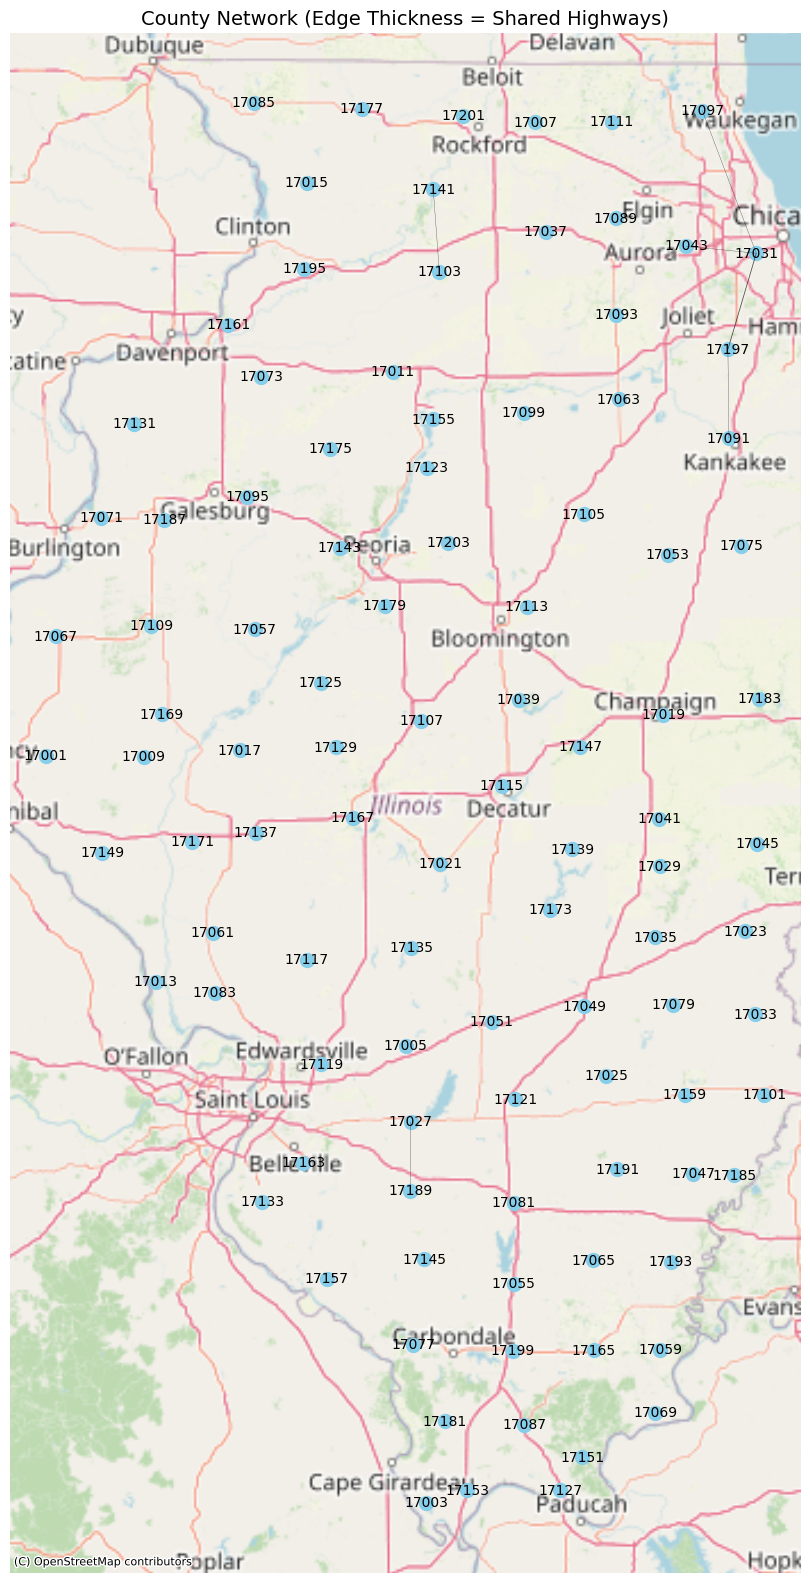

In [308]:
fig, ax = plt.subplots(figsize=(20, 20))

# Draw edges with thickness by weight
edges_filtered.plot(
    ax=ax,
    linewidth=edges['weight'] / 10000,  # thicker = stronger connection
    color='black',
    alpha=0.7
)

# Draw nodes
nodes.plot(ax=ax, color='skyblue', markersize=100)

# Add labels (county names)
for x, y, label in zip(nodes.geometry.x, nodes.geometry.y, nodes['county']):
    ax.text(x, y, label, fontsize=10, ha='center', va='center')

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_axis_off()
plt.title("County Network (Edge Thickness = Shared Highways)", fontsize=14)
plt.show()


In [315]:
nodes.county.to_csv('il_counties.csv', index=False)

## Variant Prevalence

In [7]:
variant = pd.read_csv('../raw data/variant_prevalence_il.csv')
variant_2 = pd.read_csv('../raw data/variant_prevalence_2_il.csv')
variant_omicron = pd.read_csv('../raw data/omicron_prevalence_il.csv')

In [8]:
variant.shape, variant_2.shape, variant_omicron.shape

((31844, 10), (12176, 10), (10809, 10))

In [9]:
combined_variant = pd.concat([variant, variant_2, variant_omicron], axis=0)

In [10]:
combined_variant.head()

,date,total_count,lineage_count,total_count_rolling,lineage_count_rolling,proportion,proportion_ci_lower,proportion_ci_upper,lineage,location
0,2021-04-22,1,1,2.00,0.500000,0.250000,0.000217,0.666822,Alpha,USA_US-IL_17001
1,2021-04-23,2,1,2.00,0.666667,0.333333,0.060830,0.939170,Alpha,USA_US-IL_17001
2,2021-04-25,1,1,1.75,0.750000,0.428571,0.060830,0.939170,Alpha,USA_US-IL_17001
3,2021-04-26,6,5,2.50,2.000000,0.800000,0.333178,0.999783,Alpha,USA_US-IL_17001
4,2021-04-27,1,1,2.20,1.800000,0.818182,0.333178,0.999783,Alpha,USA_US-IL_17001


In [11]:
exo_il_counties

,date,confirmed,deaths,recovered,tests,vaccines,people_vaccinated,people_fully_vaccinated,hosp,icu,...,containment_health_index,economic_support_index,administrative_area_level,administrative_area_level_1,administrative_area_level_3,latitude,longitude,population,key_local,key_nuts
186358,2020-04-16,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-63.1,-87.5,3,United States,Alexander,37.15312,-89.347391,5761,17003.0,NaN
186359,2020-04-17,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-63.1,-87.5,3,United States,Alexander,37.15312,-89.347391,5761,17003.0,NaN
186360,2020-04-18,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-63.1,-87.5,3,United States,Alexander,37.15312,-89.347391,5761,17003.0,NaN
186361,2020-04-19,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-63.1,-87.5,3,United States,Alexander,37.15312,-89.347391,5761,17003.0,NaN
186362,2020-04-20,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-63.1,-87.5,3,United States,Alexander,37.15312,-89.347391,5761,17003.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3592530,2023-04-12,NaN,NaN,NaN,NaN,NaN,21083.0,19190.0,NaN,NaN,...,NaN,NaN,3,United States,Bureau,41.38703,-89.511034,32628,17011.0,NaN
3592531,2023-04-19,NaN,NaN,NaN,NaN,NaN,21082.0,19187.0,NaN,NaN,...,NaN,NaN,3,United States,Bureau,41.38703,-89.511034,32628,17011.0,NaN
3592532,2023-04-26,NaN,NaN,NaN,NaN,NaN,21090.0,19193.0,NaN,NaN,...,NaN,NaN,3,United States,Bureau,41.38703,-89.511034,32628,17011.0,NaN
3592533,2023-05-03,NaN,NaN,NaN,NaN,NaN,21101.0,19198.0,NaN,NaN,...,NaN,NaN,3,United States,Bureau,41.38703,-89.511034,32628,17011.0,NaN


In [12]:
props = combined_variant[['date', 'proportion', 'lineage', 'location']]
props.head()

,date,proportion,lineage,location
0,2021-04-22,0.250000,Alpha,USA_US-IL_17001
1,2021-04-23,0.333333,Alpha,USA_US-IL_17001
2,2021-04-25,0.428571,Alpha,USA_US-IL_17001
3,2021-04-26,0.800000,Alpha,USA_US-IL_17001
4,2021-04-27,0.818182,Alpha,USA_US-IL_17001


In [13]:
props.location = props.location.apply(lambda x: x[-5:])
props

C:\Users\hkdeb\AppData\Local\Temp\ipykernel_2492\3482741979.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  props.location = props.location.apply(lambda x: x[-5:])


,date,proportion,lineage,location
0,2021-04-22,0.250000,Alpha,17001
1,2021-04-23,0.333333,Alpha,17001
2,2021-04-25,0.428571,Alpha,17001
3,2021-04-26,0.800000,Alpha,17001
4,2021-04-27,0.818182,Alpha,17001
...,...,...,...,...
10804,2024-06-20,1.000000,omicron_3,17201
10805,2024-07-09,1.000000,omicron_3,17201
10806,2022-04-09,1.000000,omicron_1,17203
10807,2022-04-12,1.000000,omicron_1,17203


In [14]:
props_ts = props.pivot_table(values='proportion', index=['location', 'date'], columns='lineage', fill_value=0).reset_index()

In [15]:
props_ts.date = pd.to_datetime(props_ts.date)

In [16]:
exo_il_counties.date = pd.to_datetime(exo_il_counties.date)
exo_il_counties.key_local = exo_il_counties.key_local.apply(lambda x: str(int(x)))

C:\Users\hkdeb\AppData\Local\Temp\ipykernel_2492\218531352.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exo_il_counties.date = pd.to_datetime(exo_il_counties.date)
C:\Users\hkdeb\AppData\Local\Temp\ipykernel_2492\218531352.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exo_il_counties.key_local = exo_il_counties.key_local.apply(lambda x: str(int(x)))


In [17]:
exo_il_counties.rename({'key_local':'location'}, axis=1, inplace=True)

C:\Users\hkdeb\AppData\Local\Temp\ipykernel_2492\2675576877.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exo_il_counties.rename({'key_local':'location'}, axis=1, inplace=True)


In [18]:
exo_il_counties.iloc[:, 1:29] = exo_il_counties.iloc[:, 1:29].map(lambda x: np.abs(x))

In [147]:
# exo_il_counties.to_csv('cases_and_exogenous_il.csv', index=False)

In [19]:
props_ts.head()

lineage,location,date,Alpha,Beta,Delta,Epsilon,Gamma,Iota,omicron_1,omicron_2,omicron_3,omicron_4
0,17001,2021-04-19,0.000000,0.0,0.0,0.0,0.666667,0.0,0.0,0.0,0.0,0.0
1,17001,2021-04-22,0.250000,0.0,0.0,0.0,0.500000,0.0,0.0,0.0,0.0,0.0
2,17001,2021-04-23,0.333333,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0
3,17001,2021-04-25,0.428571,0.0,0.0,0.0,0.285714,0.0,0.0,0.0,0.0,0.0
4,17001,2021-04-26,0.800000,0.0,0.0,0.0,0.100000,0.0,0.0,0.0,0.0,0.0


In [20]:
props_ts.iloc[:,2:].sum(axis=1).max()

1.0000000000000009

In [35]:
props_ts.to_csv('pivoted_prevalences.csv', index=False)

In [21]:
props_ts['Omicron'] = props_ts.iloc[:, -4:].sum(axis=1)

In [22]:
props_ts = props_ts.drop(['omicron_1', 'omicron_2', 'omicron_3', 'omicron_4'], axis=1)

In [23]:
prop_ts_dfilled = (props_ts
       .set_index(['location', 'date'])    
       .groupby(level=0)                     
       .apply(lambda g: g.droplevel(0).asfreq('D'))  
       .reset_index())                       


In [24]:
prop_ts_dfilled

lineage,location,date,Alpha,Beta,Delta,Epsilon,Gamma,Iota,Omicron
0,17001,2021-04-19,0.000000,0.0,0.0,0.0,0.666667,0.0,0.0
1,17001,2021-04-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,17001,2021-04-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,17001,2021-04-22,0.250000,0.0,0.0,0.0,0.500000,0.0,0.0
4,17001,2021-04-23,0.333333,0.0,0.0,0.0,0.333333,0.0,0.0
...,...,...,...,...,...,...,...,...,...
90205,17203,2022-07-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90206,17203,2022-07-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90207,17203,2022-07-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90208,17203,2022-07-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
num_cols = prop_ts_dfilled.select_dtypes(include='number').columns

out = (prop_ts_dfilled.groupby('location', group_keys=False)
         .apply(lambda g: (g.set_index('date')
                             .assign(**{
                               col: g.set_index('date')[col]
                                       .interpolate(method='time', limit_area='inside')
                               for col in num_cols
                             })
                             .reset_index()))
      )


C:\Users\hkdeb\AppData\Local\Temp\ipykernel_2492\3993828435.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = (prop_ts_dfilled.groupby('location', group_keys=False)


In [68]:
out[num_cols].sum(axis=1).max()

1.0000000000000009

In [69]:
exo_il_counties.shape

(111577, 37)

In [26]:
out.shape

(90210, 9)

In [35]:
combined = exo_il_counties.merge(out, on=['date', 'location'], how='right')

In [37]:
combined_full_interp = (combined.groupby('location', group_keys=False)
         .apply(lambda g: (g.set_index('date')
                             .assign(**{
                               col: g.set_index('date')[col]
                                       .interpolate(method='time', limit_area='inside')
                               for col in num_cols
                             })
                             .reset_index()))
      )


C:\Users\hkdeb\AppData\Local\Temp\ipykernel_2492\3716632303.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  combined_full_interp = (combined.groupby('location', group_keys=False)


In [38]:
combined_full_interp

,date,confirmed,deaths,recovered,tests,vaccines,people_vaccinated,people_fully_vaccinated,hosp,icu,...,population,location,key_nuts,Alpha,Beta,Delta,Epsilon,Gamma,Iota,Omicron
0,2021-04-19,8195.0,146.0,NaN,NaN,NaN,26456.0,21371.0,NaN,NaN,...,65435.0,17001,NaN,0.000000,0.0,0.0,0.0,0.666667,0.0,0.0
1,2021-04-20,8212.0,146.0,NaN,NaN,NaN,26484.0,21396.0,NaN,NaN,...,65435.0,17001,NaN,0.083333,0.0,0.0,0.0,0.611111,0.0,0.0
2,2021-04-21,8231.0,146.0,NaN,NaN,NaN,26535.0,21581.0,NaN,NaN,...,65435.0,17001,NaN,0.166667,0.0,0.0,0.0,0.555556,0.0,0.0
3,2021-04-22,8243.0,146.0,NaN,NaN,NaN,26579.0,21705.0,NaN,NaN,...,65435.0,17001,NaN,0.250000,0.0,0.0,0.0,0.500000,0.0,0.0
4,2021-04-23,8254.0,146.0,NaN,NaN,NaN,26636.0,21868.0,NaN,NaN,...,65435.0,17001,NaN,0.333333,0.0,0.0,0.0,0.333333,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,2022-07-07,11206.0,125.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,38459.0,17203,NaN,0.000000,0.0,0.0,0.0,0.000000,0.0,1.0
90,2022-07-08,11218.0,125.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,38459.0,17203,NaN,0.000000,0.0,0.0,0.0,0.000000,0.0,1.0
91,2022-07-09,11218.0,125.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,38459.0,17203,NaN,0.000000,0.0,0.0,0.0,0.000000,0.0,1.0
92,2022-07-10,11218.0,125.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,38459.0,17203,NaN,0.000000,0.0,0.0,0.0,0.000000,0.0,1.0


In [28]:
# combined.ffill(inplace=True)

In [31]:
span = (out.groupby('location')['date']
          .agg(start='min', end='max')
          .assign(days_exclusive=lambda s: (s['end'] - s['start']).dt.days,
                  days_inclusive=lambda s: (s['end'] - s['start']).dt.days + 1))


In [39]:
combined.shape

(90210, 44)

In [40]:
combined.to_csv('combined_covariates_interpolated.csv', index=False)

### Check for drops in cumulative counts

In [110]:
tmp = combined.sort_values(['location', 'date'])

In [111]:
tmp.diff = tmp.groupby('location').confirmed.diff()

In [113]:
tmp['cumulative_drop'] = tmp.diff < 0

In [114]:
tmp[tmp.cumulative_drop]

,date,confirmed,deaths,recovered,tests,vaccines,people_vaccinated,people_fully_vaccinated,hosp,icu,...,latitude,longitude,population,location,key_nuts,Alpha,Delta,Epsilon,Iota,cumulative_drop
8425,2022-04-13,2407.0,21.0,NaN,NaN,NaN,3886.0,3546.0,NaN,NaN,...,39.975016,-90.714212,6578,17009,NaN,0.000000,0.000000,0.0,0.0,True
424,2021-04-20,1947.0,33.0,NaN,NaN,NaN,4580.0,3751.0,NaN,NaN,...,39.997740,-90.250383,12147,17017,NaN,0.666667,0.000000,0.0,0.0,True
865,2021-04-18,2089.0,41.0,NaN,NaN,NaN,6412.0,5141.0,NaN,NaN,...,39.013556,-87.758747,18667,17033,NaN,0.800000,0.000000,0.0,0.0,True
4537,2021-06-29,3227.0,58.0,NaN,NaN,NaN,5734.0,4507.0,NaN,NaN,...,38.984745,-89.031018,21336,17051,NaN,0.000000,1.000000,0.0,0.0,True
4647,2022-04-14,12266.0,177.0,NaN,NaN,NaN,19015.0,17265.0,NaN,NaN,...,37.993256,-88.926139,38469,17055,NaN,0.000000,0.000000,0.0,0.0,True
4649,2022-05-02,12245.0,177.0,NaN,NaN,NaN,19066.0,17345.0,NaN,NaN,...,37.993256,-88.926139,38469,17055,NaN,0.000000,0.000000,0.0,0.0,True
4517,2022-04-11,1406.0,18.0,NaN,NaN,NaN,2970.0,2655.0,NaN,NaN,...,37.740509,-88.215875,4828,17059,NaN,0.000000,0.000000,0.0,0.0,True
7439,2022-03-03,147308.0,1405.0,NaN,NaN,NaN,614687.0,534847.0,NaN,NaN,...,42.326845,-88.013105,696535,17097,NaN,0.000000,0.000000,0.0,0.0,True
243,2021-07-07,18584.0,227.0,NaN,NaN,NaN,99165.0,77803.0,NaN,NaN,...,40.528681,-88.863259,171517,17113,NaN,0.000000,1.000000,0.0,0.0,True
3634,2021-03-30,4032.0,88.0,NaN,NaN,NaN,8923.0,5611.0,NaN,NaN,...,38.011681,-89.829998,31782,17157,NaN,0.800000,0.000000,0.1,0.0,True


Ends up being pretty rare

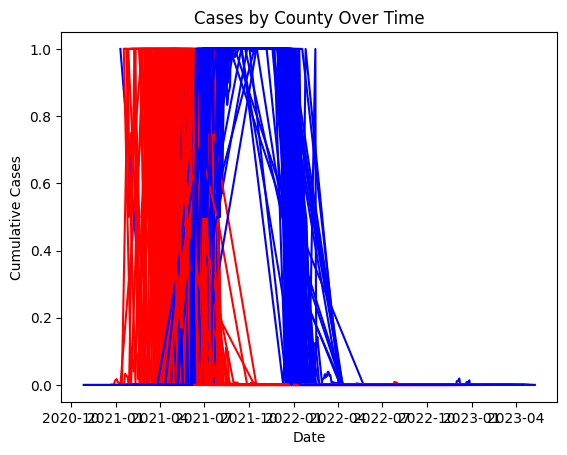

In [120]:
for name, group in combined.groupby('location'):
    plt.plot(group['date'], group['Alpha'], label=name, color='red')
    plt.plot(group['date'], group['Delta'], label=name, color='blue')


# plt.legend(title='County')
plt.xlabel('Date')
plt.ylabel('Cumulative Cases')
plt.title('Cases by County Over Time')
plt.show()


In [130]:
combined.iloc[:, 1:29] = combined.iloc[:, 1:29].map(lambda x: np.abs(x))

In [134]:
combined.to_csv('combined_prevalence_and_exogenous.csv', index=False)

In [135]:
combined.location.value_counts()

location
17031    823
17119    394
17097    388
17145    314
17163    296
        ... 
17131     12
17013     11
17151      9
17071      8
17199      1
Name: count, Length: 97, dtype: int64